In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import mixed_precision
from google.colab import drive

In [9]:
# GPUs
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

        gpu_details = tf.config.experimental.get_device_details(gpus[0])
        print(f"GPU Detected: {gpu_details['device_name']}")

    except RuntimeError as e:
        print(e)
else:
    print("Not running on GPU")

if gpus:
    policy = mixed_precision.Policy('mixed_float16')
    mixed_precision.set_global_policy(policy)
    print("Mixed Precision enabled (faster training on T4)")

GPU Detected: Tesla T4
Mixed Precision enabled (faster training on T4)


## Data import from drive

We will train and test the LSTM model on house 1 because of its continuity. This will allow the model to pick up nuances of the temporal data better.


In [3]:
drive.mount('/content/drive')

base_path = '/content/drive/MyDrive/a/'
file_h1 = base_path + 'House_1_cleaned.csv'
df = pd.read_csv(file_h1, parse_dates=['index'], index_col='index')
df.columns = ['House_1_Power']

Mounted at /content/drive


In [4]:
# 1-minute resampling
df_resampled = df.resample('1min').mean().fillna(0)
data = df_resampled[['House_1_Power']].values

## Preprocessing and scaling

In [20]:
lb = 60 * 24 # 60 min * 24 hours look back

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# look back + next 1 min
def create_dataset(dataset, look_back=lb):
    X, y = [], []
    for i in range(look_back, len(dataset)):
        X.append(dataset[i-look_back:i, 0])
        y.append(dataset[i, 0])
    return np.array(X), np.array(y)

X, y = create_dataset(scaled_data, lb)
train_size = int(len(X) * 0.8) # 80/20 split

# reshape for LSTM
X = np.reshape(X, (X.shape[0], X.shape[1], 1))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"Training shape: {X_train.shape}")
print(f"Testing shape: {X_test.shape}")

Training shape: (269040, 1440, 1)
Testing shape: (67261, 1440, 1)


## Model build

In [ ]:
model = Sequential()

# Layer 1
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))

# Layer 2
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Output Layer
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)

# Plot loss graph
plt.figure(figsize=(12, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('House 1 LSTM Training Progress')
plt.legend()
plt.show()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
2978/4204 ━━━━━━━━━━━━━━━━━━━━ 1:35 78ms/step - loss: 4.7798e-04

In [10]:
# Model analysis
predictions = model.predict(X_test)
predictions_actual = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

mse = mean_squared_error(y_test_actual, predictions_actual)
rmse = math.sqrt(mse)
mae = mean_absolute_error(y_test_actual, predictions_actual)
r2 = r2_score(y_test_actual, predictions_actual)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R-squared Score: {r2:.4f}")

2111/2111 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step
RMSE: 24.72
MAE: 1.98
R-squared Score: 0.7681


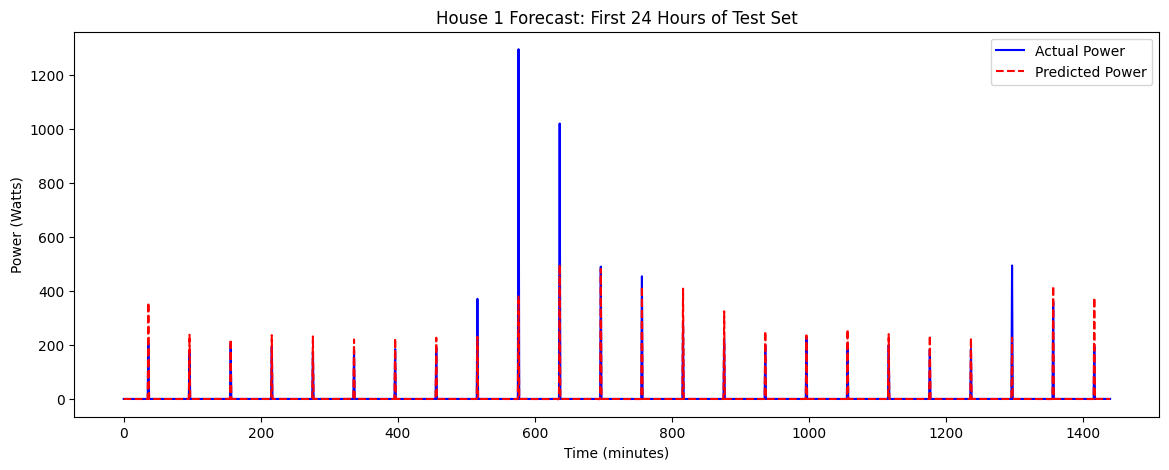

In [16]:
# Plot day to see how well it fits daily patterns

plt.figure(figsize=(14, 5))
plt.plot(y_test_actual[:1440], color='blue', label='Actual Power')
plt.plot(predictions_actual[:1440], color='red', linestyle='--', label='Predicted Power')
plt.title('House 1 Forecast: First 24 Hours of Test Set')
plt.xlabel('Time (minutes)')
plt.ylabel('Power (Watts)')
plt.legend()
plt.show()

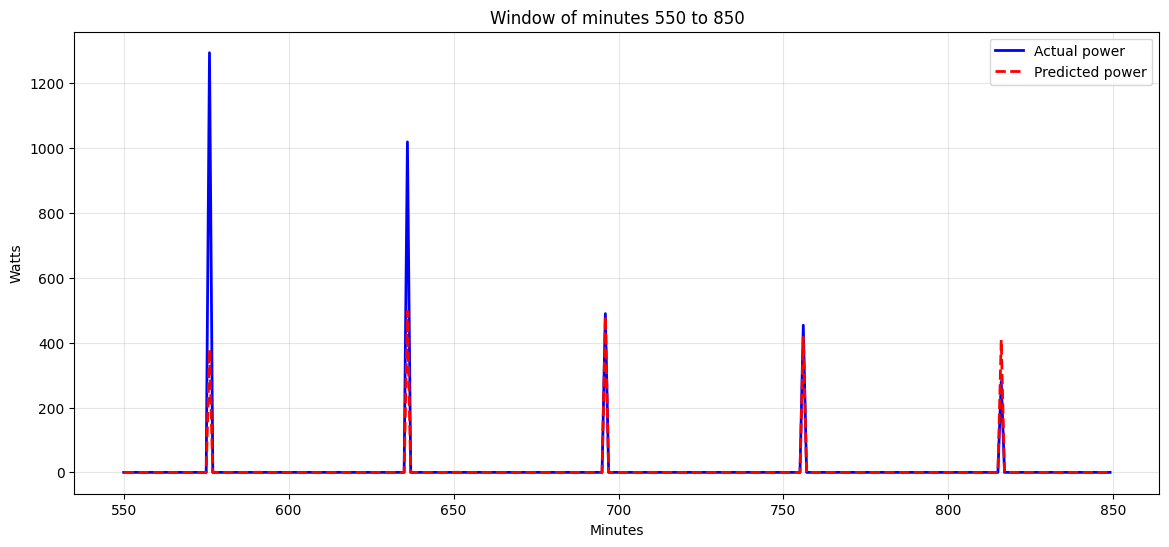

In [13]:
# Window zoom in on slice of day to see how well it fits daily patterns
start_idx = 550
end_idx = 850

plt.figure(figsize=(14, 6))
plt.plot(range(start_idx, end_idx), y_test_actual[start_idx:end_idx],
         color='blue', label='Actual power', linewidth=2)
plt.plot(range(start_idx, end_idx), predictions_actual[start_idx:end_idx],
         color='red', linestyle='--', label='Predicted power', linewidth=2)

plt.title(f'Window of minutes {start_idx} to {end_idx}')
plt.xlabel('Minutes')
plt.ylabel('Watts')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

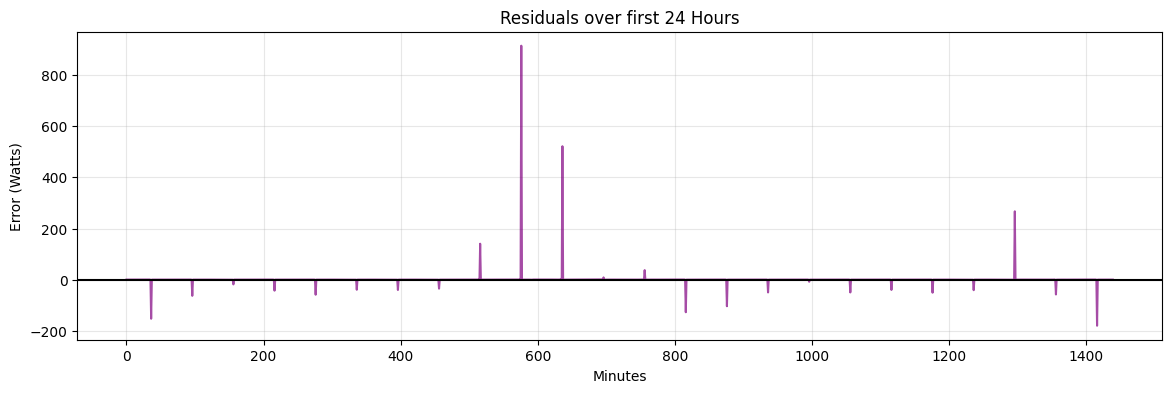

In [15]:
residuals = y_test_actual[:1440] - predictions_actual[:1440]

plt.figure(figsize=(14, 4))
plt.plot(residuals, color='purple', alpha=0.7)
plt.axhline(y=0, color='black', linestyle='-')
plt.title('Residuals over first 24 Hours')
plt.xlabel('Minutes')
plt.ylabel('Error (Watts)')
plt.grid(True, alpha=0.3)
plt.show()

In [19]:
# Native baseline comparison, just to check
naive_mse = mean_squared_error(y_test_actual[1:], y_test_actual[:-1])
naive_rmse = math.sqrt(naive_mse)

print(f"RMSE: {rmse:.4f}")
print(f"Baseline RMSE: {naive_rmse:.4f}")

RMSE: 24.7185
Baseline RMSE: 73.0225
